In [1]:
import os
import shutil
import time
import json

In [2]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, Sequential
from keras.src.applications.convnext import ConvNeXtXLarge
from keras.src.applications.efficientnet_v2 import EfficientNetV2L
from keras.src.applications.inception_resnet_v2 import InceptionResNetV2
from keras.src.applications.resnet_v2 import ResNet50V2
from keras.src.applications.vgg16 import VGG16
from keras.src.applications.xception import Xception
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.utils import image_dataset_from_directory
from pandas import DataFrame
from plot_keras_history import show_history

2024-09-20 17:39:01.183274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 17:39:01.223422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 17:39:01.238418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 17:39:01.259917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 17:39:02.099453: W tensorflow/compiler/tf2

In [3]:
CROPPED_IMAGES_PATH = "resources/Cropped_Images"
MODELS_PATH = "models/transfer_learning"

In [4]:
def remove_last_generated_models():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)

In [5]:
def get_dataset(path, image_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [6]:
def create_model(image_size, base_model):
    for layer in base_model.layers:
        layer.trainable = False
        
    data_augmentation_layers = Sequential([
        layers.RandomFlip("horizontal", input_shape=image_size + (3,)),
        layers.RandomRotation(0.1)
    ])
    
    model = Sequential([
        # Data augmentation
        data_augmentation_layers,

        # Pre-trained model without the top
        base_model,

        # Convert the feature map from the encoder part of the model (without the top) to a vector
        layers.GlobalAveragePooling2D(),

        # Fully connected layers (all neurons are linked to the others).
        layers.Dense(256, activation='relu'),

        # Dropout layer to prevent overfitting. Randomly stops some neurons for each image so that the other neurons have to adapt to that, to reduce overfitting.
        layers.Dropout(0.2),

        # Output layer with the same layer as your labels. Softmax to allow the model to predict the probability of each class.
        layers.Dense(120, activation='softmax')
    ])

    # Crossentropy as we're getting closer to a correct prediction of the labels.
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # print(model.summary())
    return model

In [7]:
def get_base_model(base_model, image_size):
    input_shape = image_size + (3,)
    preprocessing_input = keras.layers.Input([224, 224, 3])
    
    match base_model:
        case "VGG16":
            return (VGG16(include_top=False, weights="imagenet", input_shape=input_shape,
                          input_tensor=keras.applications.vgg16.preprocess_input(preprocessing_input)))
        case "Xception":
            return (Xception(include_top=False, weights="imagenet", input_shape=input_shape,
                             input_tensor=keras.applications.xception.preprocess_input(preprocessing_input)))
        case "ResNet50V2":
            return (ResNet50V2(include_top=False, weights="imagenet", input_shape=input_shape,
                               input_tensor=keras.applications.resnet_v2.preprocess_input(preprocessing_input)))
        case "InceptionResNetV2":
            return (InceptionResNetV2(include_top=False, weights="imagenet", input_shape=input_shape,
                                      input_tensor=keras.applications.inception_resnet_v2.preprocess_input(
                                          preprocessing_input)))
        case "EfficientNetV2L":
            # The preprocessing logic has been included in the EfficientNetV2 model implementation.
            return EfficientNetV2L(include_top=False, weights="imagenet", input_shape=input_shape)
            
        case "ConvNeXtXLarge":
            # The preprocessing logic has been included in the convnext model implementation.
            return ConvNeXtXLarge(include_top=False, weights="imagenet", input_shape=input_shape)
            
        case _:
            return None

In [8]:
def display_results_plots(results):
    display_results_plot(results, ["fitting_time"], "fitting_time")
    display_results_plot(results, ["test_accuracy", "val_accuracy"], "accuracies", ascending=False)
    display_results_plot(results, ["test_loss", "val_loss"], "losses")

In [9]:
def display_results_plot(results, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)

    performance_plot = (results[metrics + ["model_name"]]
                        .plot(kind="line", x="model_name", figsize=(15, 8), rot=0,
                              title=f"Models Sorted by {metrics_name}"))
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    performance_plot.set(xlabel=None)

    plt.show()
    plt.close()

Starting transfer learning script.

Found 20580 files belonging to 120 classes.
Using 15435 files for training.


I0000 00:00:1726828744.007892  198060 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726828744.052548  198060 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726828744.055288  198060 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726828744.059139  198060 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 20580 files belonging to 120 classes.
Using 5145 files for validation.
Found 20580 files belonging to 120 classes.
Training model VGG16.

Epoch 1/100


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:218: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
2024-09-20 17:39:08.659065: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726828748.723742  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828748.741531  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828748.744396  198199 gpu_

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1937 - loss: 4.5397

W0000 00:00:1726828800.902697  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.903723  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.904703  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.905770  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.906782  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.908003  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.909208  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.910800  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828800.912811  198195 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1939 - loss: 4.5365

W0000 00:00:1726828802.482223  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.485831  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.489522  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.492870  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.496238  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.499884  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.503071  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.506614  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828802.510253  198195 gp


Epoch 1: val_loss improved from inf to 1.28312, saving model to models/transfer_learning/VGG16_best_weights.keras


W0000 00:00:1726828822.200924  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.203484  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.206022  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.208478  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.212572  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.216083  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.220988  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726828822.228152  198196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


483/483 ━━━━━━━━━━━━━━━━━━━━ 75s 142ms/step - accuracy: 0.1942 - loss: 4.5333 - val_accuracy: 0.6212 - val_loss: 1.2831
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5640 - loss: 1.5500
Epoch 2: val_loss improved from 1.28312 to 1.02721, saving model to models/transfer_learning/VGG16_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 64s 133ms/step - accuracy: 0.5640 - loss: 1.5497 - val_accuracy: 0.6956 - val_loss: 1.0272
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6383 - loss: 1.2396
Epoch 3: val_loss improved from 1.02721 to 0.96577, saving model to models/transfer_learning/VGG16_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 64s 133ms/step - accuracy: 0.6383 - loss: 1.2395 - val_accuracy: 0.7073 - val_loss: 0.9658
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6726 - loss: 1.0946
Epoch 4: val_loss improved from 0.96577 to 0.94224, saving model to models/transfer_learning/VGG16_best_weights.keras
483/483 ━━━━━━━━━━━

W0000 00:00:1726829413.305570  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.306382  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.307154  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.307976  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.308768  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.309638  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.310503  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.311509  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829413.312576  198189 gp


Test Accuracy:0.7832361459732056.



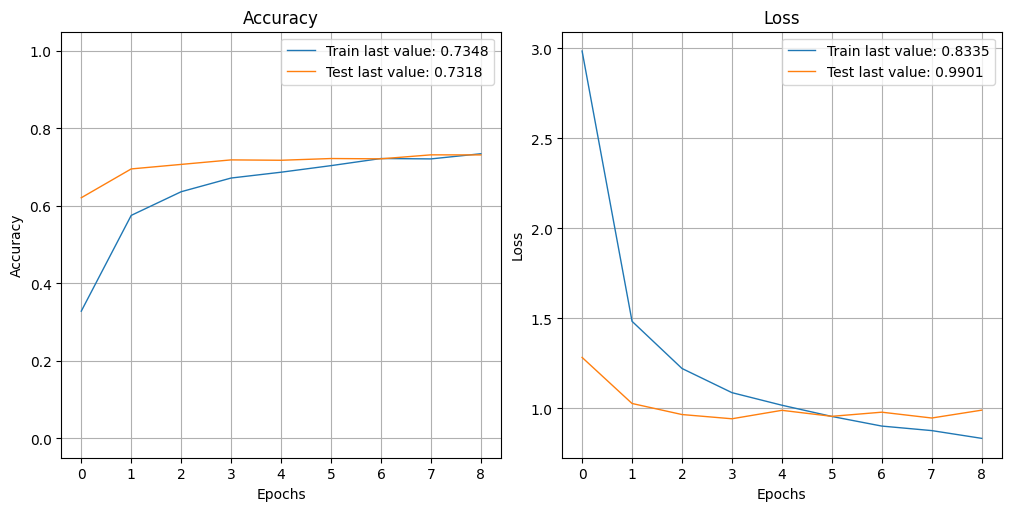

Training model Xception.

Epoch 1/100


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:218: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_34']. Received: the structure of inputs=*
  warnings.warn(
W0000 00:00:1726829418.030882  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.031721  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.032546  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.033438  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.034329  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.035193  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:17268

  3/483 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.0069 - loss: 4.8885    

W0000 00:00:1726829418.460539  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.461477  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.462417  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.463397  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.464316  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.465243  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.466204  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.467126  198189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829418.468052  198189 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5957 - loss: 1.8353

W0000 00:00:1726829452.324385  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.325072  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.325713  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.326379  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.327050  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.327721  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.328381  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.329133  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.329882  198198 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5959 - loss: 1.8338

W0000 00:00:1726829452.525125  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.525826  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.526553  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.527253  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.527961  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.528673  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.529371  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.530089  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829452.530799  198198 gp


Epoch 1: val_loss improved from inf to 0.46356, saving model to models/transfer_learning/Xception_best_weights.keras


W0000 00:00:1726829464.281333  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.282592  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.283858  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.285202  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.286457  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.287738  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.289052  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.290325  198192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829464.291608  198192 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 96ms/step - accuracy: 0.5962 - loss: 1.8324 - val_accuracy: 0.8480 - val_loss: 0.4636
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8097 - loss: 0.6532
Epoch 2: val_loss improved from 0.46356 to 0.44203, saving model to models/transfer_learning/Xception_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 94ms/step - accuracy: 0.8097 - loss: 0.6532 - val_accuracy: 0.8599 - val_loss: 0.4420
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8244 - loss: 0.5909
Epoch 3: val_loss did not improve from 0.44203
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.8244 - loss: 0.5910 - val_accuracy: 0.8455 - val_loss: 0.4726
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8285 - loss: 0.5524
Epoch 4: val_loss did not improve from 0.44203
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.8285 - loss: 0.5525 - val_accuracy: 0.8634 - val_loss: 0.4422
Epoch 5/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 7

W0000 00:00:1726829971.294077  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.294706  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.295320  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.295967  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.296593  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.297214  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.297850  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.298496  198197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829971.299135  198197 gp


Test Accuracy:0.9044217467308044.



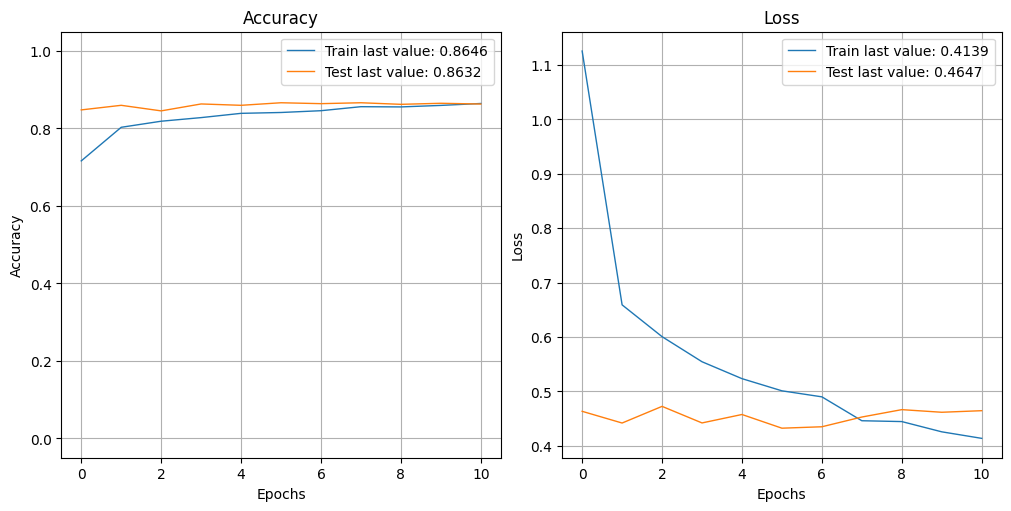

Training model ResNet50V2.

Epoch 1/100


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:218: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_178']. Received: the structure of inputs=*
  warnings.warn(
W0000 00:00:1726829976.189070  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.190592  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.192109  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.193814  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.195712  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.197852  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726

  2/483 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.0234 - loss: 5.2338

W0000 00:00:1726829976.591908  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.592734  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.593552  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.594387  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.595208  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.595980  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.596741  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.597523  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726829976.598295  198193 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4847 - loss: 2.1683

W0000 00:00:1726830003.210243  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.211163  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.212047  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.212969  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.213930  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.215185  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.216222  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.217450  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.218482  198199 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4850 - loss: 2.1668

W0000 00:00:1726830003.412567  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.413242  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.413977  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.414706  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.426758  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.427546  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.428286  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.429019  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830003.429736  198199 gp


Epoch 1: val_loss improved from inf to 0.69030, saving model to models/transfer_learning/ResNet50V2_best_weights.keras


W0000 00:00:1726830013.267672  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830013.268944  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830013.270491  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830013.273176  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


483/483 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.4852 - loss: 2.1653 - val_accuracy: 0.7852 - val_loss: 0.6903
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7488 - loss: 0.8289
Epoch 2: val_loss improved from 0.69030 to 0.65854, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.7488 - loss: 0.8290 - val_accuracy: 0.7946 - val_loss: 0.6585
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7754 - loss: 0.7332
Epoch 3: val_loss improved from 0.65854 to 0.65639, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.7754 - loss: 0.7332 - val_accuracy: 0.7967 - val_loss: 0.6564
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7942 - loss: 0.6505
Epoch 4: val_loss improved from 0.65639 to 0.63520, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
483/483 ━━

W0000 00:00:1726830376.785818  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.786558  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.787258  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.787978  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.788717  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.789551  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.790301  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.791122  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830376.791874  198198 gp


Test Accuracy:0.8742468357086182.



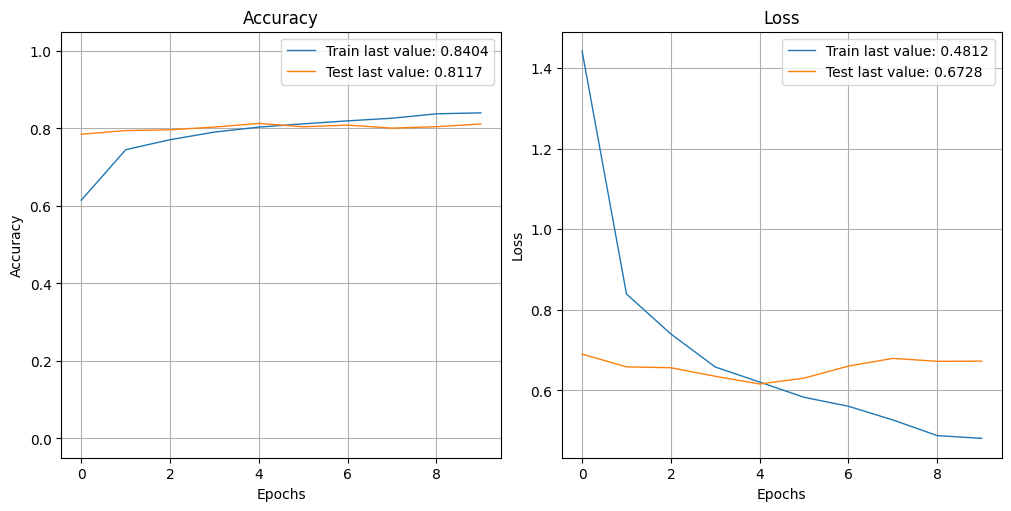

Training model InceptionResNetV2.

Epoch 1/100


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:218: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_380']. Received: the structure of inputs=*
  warnings.warn(
W0000 00:00:1726830390.329950  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830390.331425  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830390.332929  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830390.334895  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830390.336319  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830390.338303  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726

  2/483 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.0312 - loss: 5.0308   

W0000 00:00:1726830391.838208  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.838779  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.839332  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.839925  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.840522  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.841111  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.841697  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.842287  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830391.842874  198198 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6872 - loss: 1.4732

W0000 00:00:1726830434.647724  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.648583  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.649405  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.650371  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.651182  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.652151  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.653152  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.653994  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830434.654999  198194 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6874 - loss: 1.4720

W0000 00:00:1726830435.456132  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.456723  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.457348  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.457935  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.458520  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.459082  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.459645  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.460209  198194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830435.460778  198194 gp


Epoch 1: val_loss improved from inf to 0.42020, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras


W0000 00:00:1726830453.445015  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.445785  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.446554  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.447419  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.448278  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.459713  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.460847  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.461768  198198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726830453.462853  198198 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 75s 131ms/step - accuracy: 0.6876 - loss: 1.4708 - val_accuracy: 0.8766 - val_loss: 0.4202
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8381 - loss: 0.5685
Epoch 2: val_loss improved from 0.42020 to 0.38963, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 58s 121ms/step - accuracy: 0.8381 - loss: 0.5685 - val_accuracy: 0.8847 - val_loss: 0.3896
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8437 - loss: 0.5493
Epoch 3: val_loss did not improve from 0.38963
483/483 ━━━━━━━━━━━━━━━━━━━━ 57s 118ms/step - accuracy: 0.8437 - loss: 0.5493 - val_accuracy: 0.8890 - val_loss: 0.3957
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8524 - loss: 0.5232
Epoch 4: val_loss did not improve from 0.38963
483/483 ━━━━━━━━━━━━━━━━━━━━ 57s 118ms/step - accuracy: 0.8524 - loss: 0.5232 - val_accuracy: 0.8776 - val_loss: 0.4105
Epoch 5/100
482/483 ━━━━━━━━━━━━

W0000 00:00:1726831224.032650  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.033369  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.034048  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.034784  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.035459  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.036227  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.036974  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.037657  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831224.038428  198193 gp


Test Accuracy:0.9097181558609009.



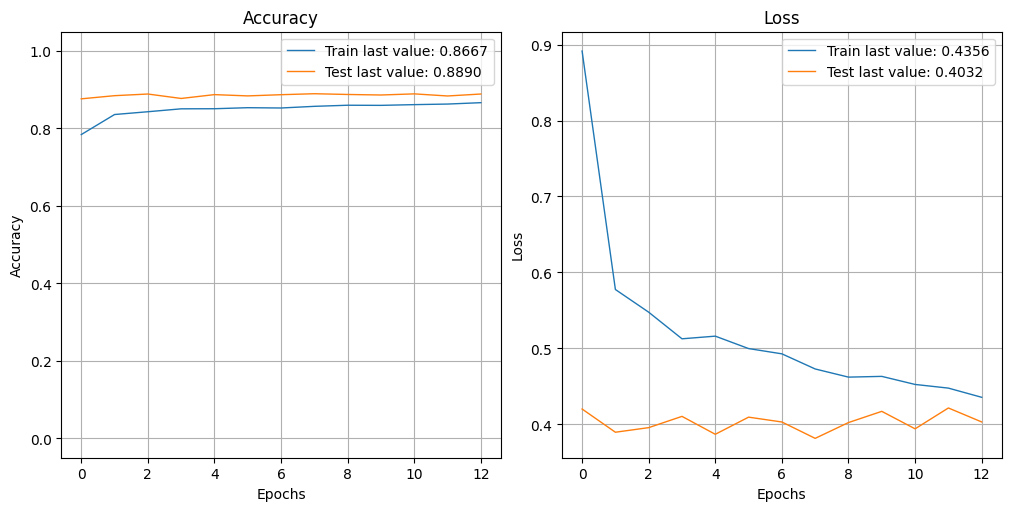

Training model EfficientNetV2L.

Epoch 1/100


W0000 00:00:1726831253.819503  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.820374  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.821220  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.822085  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.822961  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.823833  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.824706  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.825867  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831253.827031  198195 gp

  1/483 ━━━━━━━━━━━━━━━━━━━━ 3:30:13 26s/step - accuracy: 0.0312 - loss: 4.7633

W0000 00:00:1726831254.728508  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.730302  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.732089  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.734457  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.736606  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.739113  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.741088  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.743196  198195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831254.745264  198195 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7592 - loss: 1.5080

W0000 00:00:1726831362.261523  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.262186  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.262795  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.263436  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.264097  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.264740  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.265455  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.266090  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.266799  198193 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7594 - loss: 1.5064

W0000 00:00:1726831362.463228  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.465020  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.467743  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.469987  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.483058  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.486334  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.487140  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.487956  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726831362.488766  198193 gp


Epoch 1: val_loss improved from inf to 0.28566, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 177s 312ms/step - accuracy: 0.7596 - loss: 1.5048 - val_accuracy: 0.9160 - val_loss: 0.2857
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9044 - loss: 0.3198
Epoch 2: val_loss did not improve from 0.28566
483/483 ━━━━━━━━━━━━━━━━━━━━ 143s 295ms/step - accuracy: 0.9044 - loss: 0.3198 - val_accuracy: 0.9166 - val_loss: 0.2907
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9076 - loss: 0.2958
Epoch 3: val_loss improved from 0.28566 to 0.27796, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 145s 300ms/step - accuracy: 0.9076 - loss: 0.2959 - val_accuracy: 0.9217 - val_loss: 0.2780
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9118 - loss: 0.2807
Epoch 4: val_loss did not improve from 0.27796
483/483 ━━━━━━━━━━━━━━━

W0000 00:00:1726833047.271854  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.272518  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.273162  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.274023  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.274651  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.275271  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.275919  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.276530  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833047.277154  198190 gp


Test Accuracy:0.942176878452301.



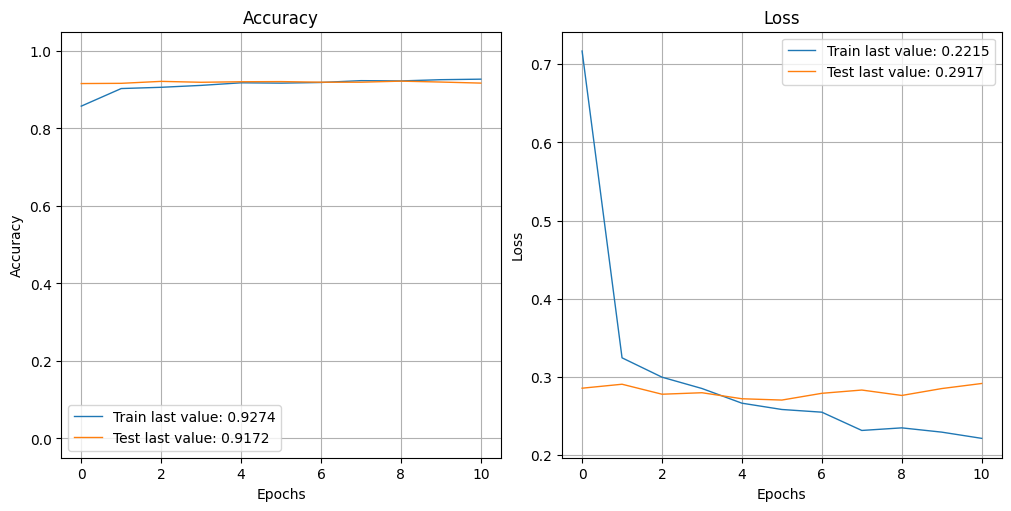

Training model ConvNeXtXLarge.

Epoch 1/100


W0000 00:00:1726833060.482033  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.483151  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.484241  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.485308  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.486552  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.487815  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.489023  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.490262  198190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726833060.491501  198190 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7690 - loss: 1.0878

W0000 00:00:1726834041.594452  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.595359  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.596209  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.597009  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.597870  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.598724  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.599593  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.600692  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834041.601719  198199 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7692 - loss: 1.0868

W0000 00:00:1726834042.803888  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.805254  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.806637  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.808040  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.809451  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.810832  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.812261  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.813789  198199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726834042.815337  198199 gp


Epoch 1: val_loss improved from inf to 0.36436, saving model to models/transfer_learning/ConvNeXtXLarge_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 1324s 3s/step - accuracy: 0.7694 - loss: 1.0857 - val_accuracy: 0.8983 - val_loss: 0.3644
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9146 - loss: 0.2959
Epoch 2: val_loss improved from 0.36436 to 0.36268, saving model to models/transfer_learning/ConvNeXtXLarge_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 1314s 3s/step - accuracy: 0.9146 - loss: 0.2959 - val_accuracy: 0.9018 - val_loss: 0.3627
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9260 - loss: 0.2448
Epoch 3: val_loss did not improve from 0.36268
483/483 ━━━━━━━━━━━━━━━━━━━━ 1308s 3s/step - accuracy: 0.9260 - loss: 0.2448 - val_accuracy: 0.9044 - val_loss: 0.3707
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9355 - loss: 0.1994
Epoch 4: val_loss improved from 0.36268 to 0.35611, saving model to models/transfer_lea

W0000 00:00:1726846491.018299  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.019139  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.019903  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.020671  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.021456  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.022244  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.023022  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.023897  198193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726846491.024746  198193 gp


Test Accuracy:0.940816342830658.



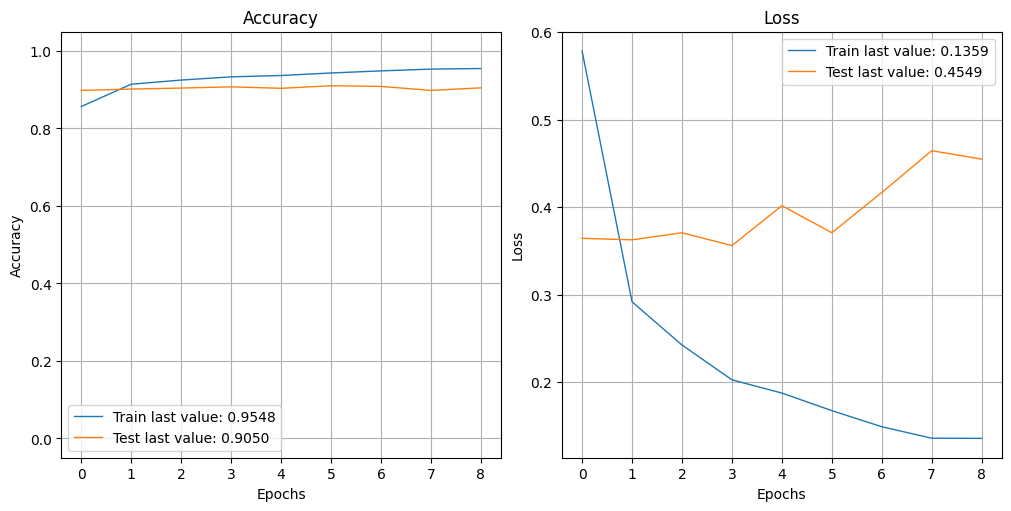

Displaying all results.



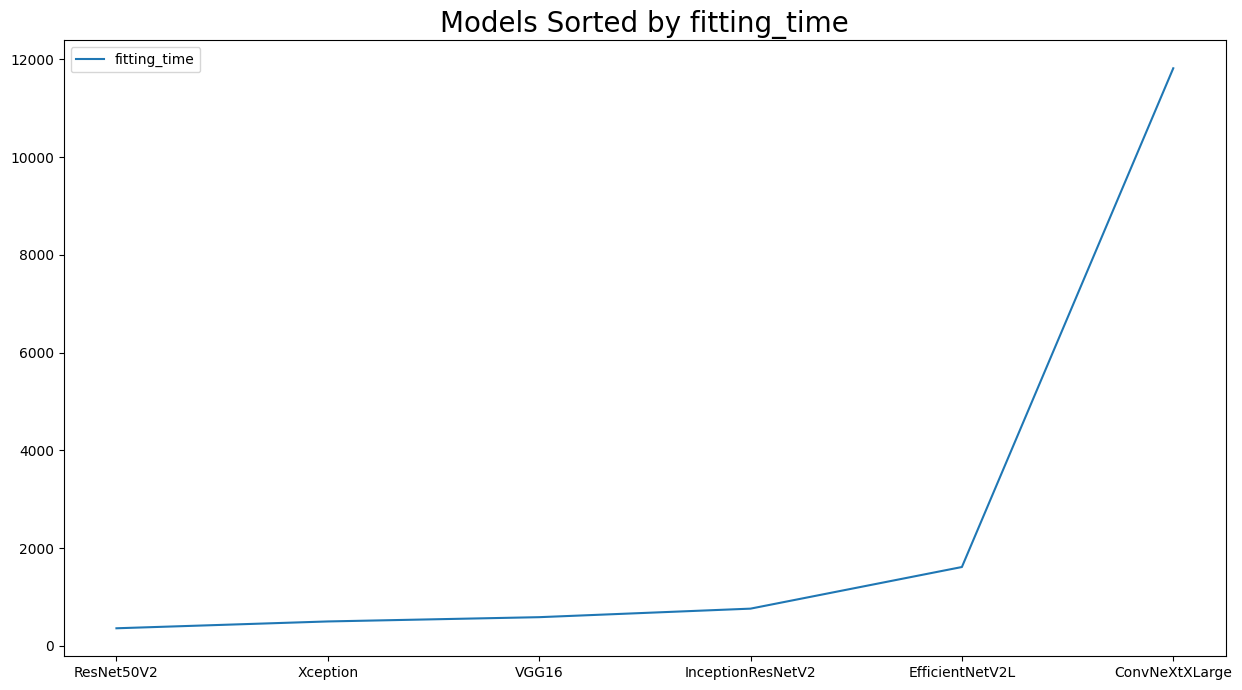

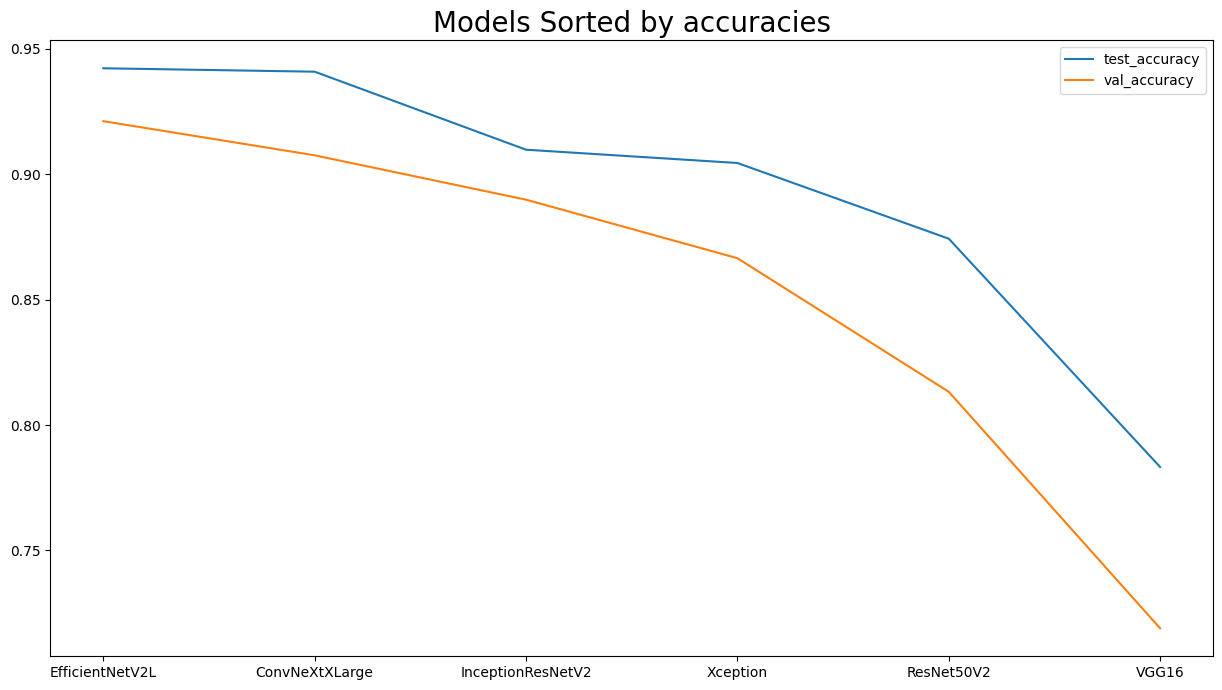

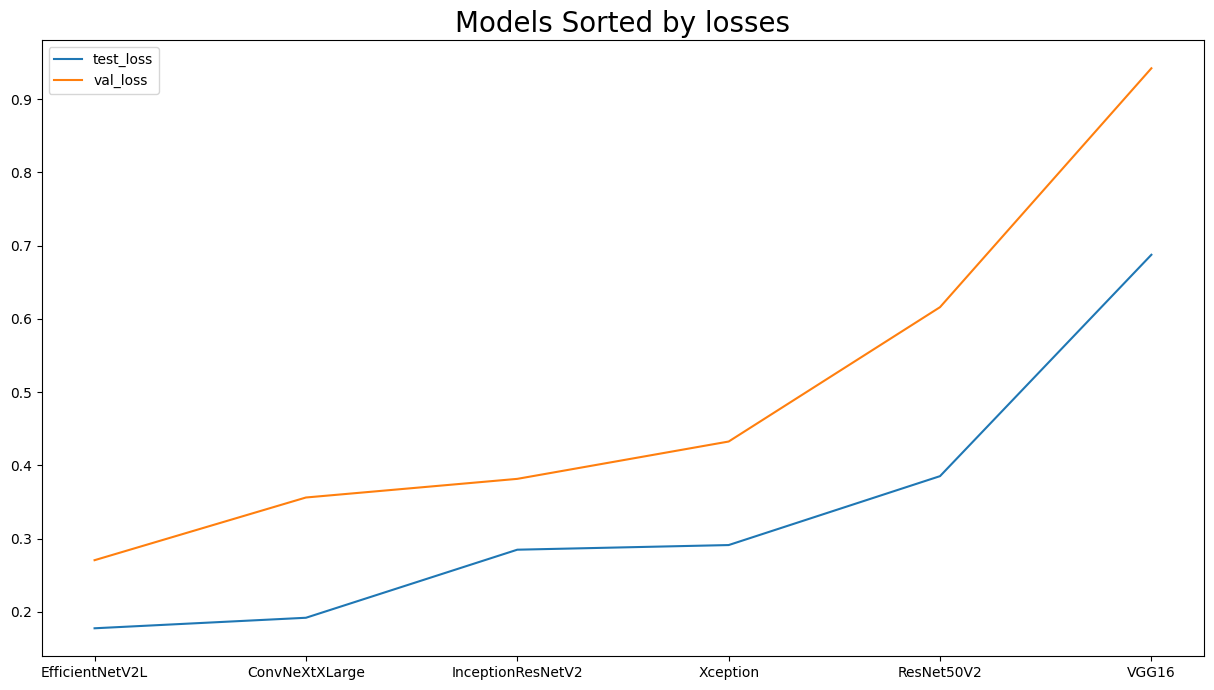

The transfer learning script is now finished.



In [10]:
print("Starting transfer learning script.\n")
remove_last_generated_models()

image_size = (224, 224)
batch_size = 32

dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, validation_split=0.25, data_type='training')
dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, validation_split=0.25, data_type='validation')
dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, data_type=None)

with tf.device('/gpu:0'):
    histories = []
    results = []
    
    for model_name in [
        "VGG16",
        "Xception",
        "ResNet50V2",
        "InceptionResNetV2",
        "EfficientNetV2L",
        "ConvNeXtXLarge"
    ]:
        print(f"Training model {model_name}.\n")

        base_model = get_base_model(model_name, image_size)

        model = create_model(image_size, base_model)
        model_save_path = f"{MODELS_PATH}/{model_name}_best_weights.keras"

        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                                     mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        callbacks_list = [checkpoint, es]

        fitting_start_time = time.time()
        history = model.fit(dataset_train,
                            validation_data=dataset_val,
                            batch_size=batch_size,
                            epochs=100,  # We want early stopping to stop the training itself
                            callbacks=callbacks_list,
                            verbose=1)
        fitting_time = time.time() - fitting_start_time

        histories.append(history)
        print("The model has been fitted, checking their loss and accuracy.\n")

        # Getting optimal epoch weights
        model.load_weights(model_save_path)

        val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
        print(f"\nValidation Accuracy:{val_accuracy}.\n")

        test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
        print(f"\nTest Accuracy:{test_accuracy}.\n")

        # For future inference
        model.export(f"{MODELS_PATH}/{model_name}_model.keras")

        results.append({
            "model_name": model_name,
            "fitting_time": fitting_time,
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss
        })

        show_history(history)
        plt.close()
    
    print("Displaying all results.\n")
    display_results_plots(DataFrame(results))

print("The transfer learning script is now finished.\n")